# Код для курсовой работы по графам в PyTorch с использованием DGL.

Ссылка на курсовую работу с описанием кода и задачей: https://docs.google.com/document/d/1zHxoU2w2nnQX36vU1WSOz7oF4dKk6M5c/edit?usp=sharing&ouid=109219613179743380702&rtpof=true&sd=true

In [108]:
!pip install dgl==0.6.1
!pip install torch==1.9.1

In [1]:
import dgl
import torch
import torch.nn as nn

Using backend: pytorch


In [2]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import random
from sklearn.metrics import r2_score
import torch.nn.functional as F

In [3]:
data=pd.read_excel('имена.xlsx')

In [4]:
name1=data['Мужские английские имена'].values
name2=data['Женские английские имена'].values
names1=[]
names2=[]
for name in name1:
    if type(name)==str:
        if len(name)!=1:
            names1.append(name)
for name in name2:
    if type(name)==str:
        if len(name)!=1:
            names2.append(name)

In [5]:
names=[names1,names2]

In [6]:
data=pd.read_excel('Фамилии.xlsx')

In [7]:
last_names=data['По-английски'].values

In [8]:
sex_node=dict()
experience_node=dict()
workhours_node=dict()
age_node=dict()
post_node=dict()
names_node=dict()
last_names_node=dict()
salary_node=dict()

In [21]:
nodes=250
G=nx.Graph()
for i in range(nodes):
    names_node[i]=random.sample(names[random.sample([0,1],1)[0]],1)[0]
    last_names_node[i]=random.sample(list(last_names),1)[0]
    if names_node[i] in names1:
        sex_node[i]='M'
    else:
        sex_node[i]='F'
    experience_node[i]=random.choices([k for k in range(1,20)],weights=[50]*15+[10]*4)[0]
    workhours_node[i]=random.sample([k for k in range(20,40)],1)[0]
    age_node[i]=random.sample([k for k in range(experience_node[i]+20,70)],1)[0]
    post_node[i]=random.choices(['Manager','Director'],weights=[20-experience_node[i]/5,experience_node[i]/5])[0]
    if sex_node[i]=='M':
        a=0
    else:
        a=1
    if post_node[i]=='Manager':
        b=0
    else:
        
        b=1
    salary_node[i]=30000-5000*a+experience_node[i]*5000+workhours_node[i]*2500+100*(35-age_node[i])+50000*b
    G.add_node(i)

In [22]:
nx.set_node_attributes(G, names_node, name="name")
nx.set_node_attributes(G, last_names_node, name="last name")
nx.set_node_attributes(G, post_node, name="post")
nx.set_node_attributes(G, sex_node, name="sex")
nx.set_node_attributes(G, age_node, name="age")
nx.set_node_attributes(G, workhours_node, name="work hours")
nx.set_node_attributes(G, experience_node, name="experience")
nx.set_node_attributes(G, salary_node, name="salary")

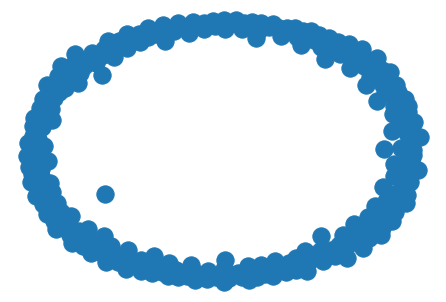

In [23]:
nx.draw(G)

In [24]:
list_edge=dict()
for i in range(len(G.nodes)-1):
    fr1=[]
    fr2=[]
    salary_i=G.nodes[i]['salary']
    for j in range(i+1,len(G.nodes)):
        salary_j=G.nodes[j]['salary']
        if math.fabs(salary_i-salary_j)<5000:
            fr1.append(j)
        else:
            if math.fabs(salary_i-salary_j)<15000:
                fr2.append(j)
    count1=min(random.sample([l+1 for l in range(5)],1)[0],len(fr1))
    count2=min(random.sample([l+1 for l in range(2)],1)[0],len(fr2))
    list_edge[i]=random.sample(fr1,count1)+random.sample(fr2,count2)

In [25]:
for edge in list_edge:
    ed=list_edge[edge]
    for ed_ in ed:
        G.add_edge(edge,ed_)

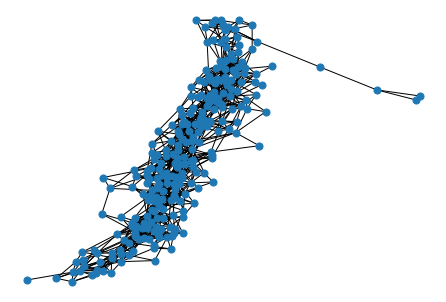

In [26]:
nx.draw(G,node_size=50)

In [27]:
H = G.copy()
salarys=[0]*len(H.nodes)
A=[]
l=['M','F','Manager','Director']
for i in range(len(H.nodes)):
    H.nodes[i].pop('name')
    H.nodes[i].pop('last name')
    l1_enc=[0]*len(l)
    l1=list(H.nodes[i].values())[0:2]
    for j in range(len(l)):
        if l[j] in l1:
            l1_enc[j]=1
        else:
            l1_enc[j]=0
    l1_enc=l1_enc+list(H.nodes[i].values())[2:-1]
    salarys[i]=H.nodes[i]['salary']
    A.append(l1_enc)

In [28]:
salarys = torch.tensor(salarys).float()

In [32]:
g = dgl.from_networkx(H)
g.ndata['label']=salarys

In [33]:
A1 = torch.tensor(A).float()
g.ndata['feat']=A1

In [34]:
from dgl.nn import SAGEConv
class Model(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'pool')
        self.conv2 = SAGEConv(h_feats, 1, 'pool')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [35]:
model = Model(g.ndata['feat'].shape[1], 10)

In [36]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    features = g.ndata['feat']
    labels = g.ndata['label']
    J=1
    for e in range(1000):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.int()

        # Compute loss
        # Note that we should only compute the losses of the nodes in the training set,
        # i.e. with train_mask 1.
        loss_l = 10
        loss = F.mse_loss(logits, labels.reshape(-1,1))
        J = loss_l-loss
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if e%100==0:
            print('In epoch {}, loss: {:.3f} r2_score: {:.3f}'.format(e, loss, r2_score(labels,pred)))
        if J==0:
            break

In epoch 0, loss: 21529030656.000 r2_score: -22.960
In epoch 100, loss: 291965120.000 r2_score: 0.675
In epoch 200, loss: 115131744.000 r2_score: 0.872
In epoch 300, loss: 59885360.000 r2_score: 0.933
In epoch 400, loss: 39369128.000 r2_score: 0.956
In epoch 500, loss: 29375992.000 r2_score: 0.967
In epoch 600, loss: 25062900.000 r2_score: 0.972
In epoch 700, loss: 23594516.000 r2_score: 0.974
In epoch 800, loss: 23109452.000 r2_score: 0.974
In epoch 900, loss: 22667292.000 r2_score: 0.975


In [37]:
sex_node=dict()
experience_node=dict()
workhours_node=dict()
age_node=dict()
post_node=dict()
names_node=dict()
last_names_node=dict()
salary_node=dict()

In [38]:
for i in range(250,251):
    names_node[i]='Mia'
    last_names_node[i]='Smith'
    sex_node[i]='F'
    experience_node[i]=15
    workhours_node[i]=30
    age_node[i]=41
    post_node[i]='Director'
    G.add_node(i)

In [39]:
nx.set_node_attributes(G, names_node, name="name")
nx.set_node_attributes(G, last_names_node, name="last name")
nx.set_node_attributes(G, post_node, name="post")
nx.set_node_attributes(G, sex_node, name="sex")
nx.set_node_attributes(G, age_node, name="age")
nx.set_node_attributes(G, workhours_node, name="work hours")
nx.set_node_attributes(G, experience_node, name="experience")

In [40]:
for i in range(len(G.nodes)):
    print(G.nodes[i])

{'name': 'Emily', 'last name': 'Alsopp', 'post': 'Manager', 'sex': 'F', 'age': 54, 'work hours': 36, 'experience': 14, 'salary': 183100}
{'name': 'Jordan', 'last name': 'Osborne', 'post': 'Manager', 'sex': 'M', 'age': 29, 'work hours': 35, 'experience': 7, 'salary': 153100}
{'name': 'Alise', 'last name': 'Fraser', 'post': 'Manager', 'sex': 'F', 'age': 34, 'work hours': 24, 'experience': 10, 'salary': 135100}
{'name': 'Zachary', 'last name': 'Hardman', 'post': 'Manager', 'sex': 'M', 'age': 24, 'work hours': 22, 'experience': 2, 'salary': 96100}
{'name': 'Mary', 'last name': 'Neal', 'post': 'Manager', 'sex': 'F', 'age': 28, 'work hours': 27, 'experience': 5, 'salary': 118200}
{'name': 'Emma', 'last name': 'Forman', 'post': 'Manager', 'sex': 'F', 'age': 35, 'work hours': 31, 'experience': 7, 'salary': 137500}
{'name': 'Ariana', 'last name': 'Quincy', 'post': 'Manager', 'sex': 'F', 'age': 30, 'work hours': 28, 'experience': 10, 'salary': 145500}
{'name': 'Charles', 'last name': 'Miller', '

In [41]:
list_edge=dict()
for i in range(250,251):
    fr1=[]
    for j in range(len(G.nodes)-1):
        if G.nodes[j]['post']=='Director':
            age=math.fabs(G.nodes[j]['age']-G.nodes[i]['age'])
            exp=math.fabs(G.nodes[j]['experience']-G.nodes[i]['experience'])
            hour=math.fabs(G.nodes[j]['work hours']-G.nodes[i]['work hours'])
            if age<5 and exp<5:
                fr1.append(j)
            if hour<5 and exp<5:
                fr1.append(j)
    count1=min(random.sample([l+1 for l in range(3,5)],1)[0],len(fr1))
    list_edge[i]=random.sample(fr1,count1)

In [42]:
for edge in list_edge:
    ed=list_edge[edge]
    for ed_ in ed:
        G.add_edge(edge,ed_)

In [43]:
list_edge

{250: [103, 206, 54, 103, 212]}

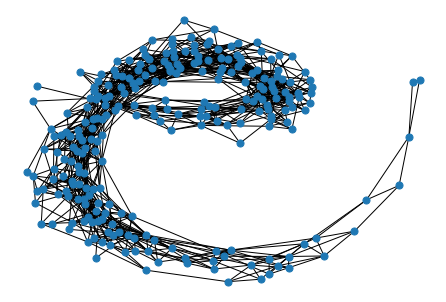

In [44]:
nx.draw(G,node_size=50)

In [45]:
H = G.copy()
l=['M','F','Manager','Director']
for i in range(250,251):
    H.nodes[i].pop('name')
    H.nodes[i].pop('last name')
    l1_enc=[0]*len(l)
    l1=list(H.nodes[i].values())[0:2]
    for j in range(len(l)):
        if l[j] in l1:
            l1_enc[j]=1
        else:
            l1_enc[j]=0
    l1_enc=l1_enc+list(H.nodes[i].values())[2:]
    A.append(l1_enc)

In [46]:
A1 = torch.tensor(A).float()

In [47]:
g = dgl.from_networkx(H)

In [48]:
logits = model(g, A1)
pred = logits.int()

In [49]:
pred[250]

tensor([215489], dtype=torch.int32)